# Analyzing Rhode Island Police Traffic Stop Activity 

Police in the USA, pull over more than 50,000 drivers on a typical day, more than 20 million motorists every year. The [Stanford Open Policing Project](https://openpolicing.stanford.edu/) a unique partnership between the [Stanford Computational Journalism Lab](http://cjlab.stanford.edu/) and the [Stanford Computational Policy Lab](https://policylab.stanford.edu/) tries to track the most common police interaction "the traffic stop".

We will use the data collected for the State of Rhode Island and try to conduct a Visual Exploratory Data Analysis and try to find answer to the below questions:

- Do the genders commit different violations?
- Does gender affect who gets a ticket for speeding?
- Does gender affect whose vehicle is searched?
- Does gender affect who is frisked during a search?
- Does time of day affect arrest rate?
- Are drug related stops on the rise?
- What violations are caused by each district?
- How long might one be stopped for a violation?

Furthermore we will try to analyze the effect of weather on policing, by trying to match up arrest rates vs the weather data.

## Cleaning Data

Before the analysis can begin the data needs to be investigated for its completeness and suitability. We will also discard information like county names and states as they are not relevant for our investigation.

In [244]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [245]:
ri = pd.read_csv('data/police.csv')
ri.head()

,state,stop_date,stop_time,county_name,driver_gender,driver_race,violation_raw,violation,search_conducted,search_type,stop_outcome,is_arrested,stop_duration,drugs_related_stop,district
0,RI,2005-01-04,12:55,NaN,M,White,Equipment/Inspection Violation,Equipment,False,NaN,Citation,False,0-15 Min,False,Zone X4
1,RI,2005-01-23,23:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone K3
2,RI,2005-02-17,04:15,NaN,M,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X4
3,RI,2005-02-20,17:15,NaN,M,White,Call for Service,Other,False,NaN,Arrest Driver,True,16-30 Min,False,Zone X1
4,RI,2005-02-24,01:20,NaN,F,White,Speeding,Speeding,False,NaN,Citation,False,0-15 Min,False,Zone X3


Counting the number of missing values in each column we drop the incomplete columns. For this we will count the number of null rows per column and compare it with the shape of our dataset

In [246]:
ri.isnull().sum()

state                     0
stop_date                 0
stop_time                 0
county_name           91741
driver_gender          5205
driver_race            5202
violation_raw          5202
violation              5202
search_conducted          0
search_type           88434
stop_outcome           5202
is_arrested            5202
stop_duration          5202
drugs_related_stop        0
district                  0
dtype: int64

In [247]:
ri.shape

(91741, 15)

The columns county_name seems to be totally empty and the column state is irrelevant for us as we have limited our analysis on to the single state of Rhode Island. Therefore we drop these two columns.

In [248]:
ri.drop(['county_name', 'state'], axis='columns', inplace=True)
ri.shape

(91741, 13)

The driver gender data is important for our analysis however there is a significant amount of rows where this data seems to be missing. We will drop such rows

In [249]:
ri.dropna(subset=['driver_gender'], inplace=True)
ri.isnull().sum()

stop_date                 0
stop_time                 0
driver_gender             0
driver_race               0
violation_raw             0
violation                 0
search_conducted          0
search_type           83229
stop_outcome              0
is_arrested               0
stop_duration             0
drugs_related_stop        0
district                  0
dtype: int64

Except for the field search_type all the other data seems to be present. The field search_type will contain data if and only if a search has been conducted i.e. the value of the search_conducted field is true. Howeever since it is false for a majority of cases, we can safely conclude that we don't have any further missing data. We will do a check on the data type for every column and see if they fit the purpose.

In [250]:
ri.dtypes

stop_date             object
stop_time             object
driver_gender         object
driver_race           object
violation_raw         object
violation             object
search_conducted        bool
search_type           object
stop_outcome          object
is_arrested           object
stop_duration         object
drugs_related_stop      bool
district              object
dtype: object

The column is_arrested should only have true or false values and therefore it should have the type boolean. However that is not the case so we need to convert it.

In [251]:
ri['is_arrested'] = ri.is_arrested.astype('bool')
ri.is_arrested.dtype

dtype('bool')

The stop_date and stop_time can be further concatenated to yield a single timestamp.

In [252]:
combined = ri.stop_date.str.cat(ri.stop_time, sep=' ')
ri['stop_datetime'] = pd.to_datetime(combined)
ri.dtypes

stop_date                     object
stop_time                     object
driver_gender                 object
driver_race                   object
violation_raw                 object
violation                     object
search_conducted                bool
search_type                   object
stop_outcome                  object
is_arrested                     bool
stop_duration                 object
drugs_related_stop              bool
district                      object
stop_datetime         datetime64[ns]
dtype: object

We can now use this datetime field as our index. And our data is then ready for analysis to answer our questions

In [253]:
ri.set_index('stop_datetime', inplace=True)

## Do the genders commit different violations?

We will try to separately group male and female drivers, calculate the percentage of violations (for speeding), the outcomes, the search rates and frisk rates. Lets start by counting various types of violations.

In [254]:
ri.violation.value_counts(normalize=True).apply(lambda x: x * 100)

Speeding               55.957058
Moving violation       18.748267
Equipment              12.620181
Other                   5.094989
Registration/plates     4.279144
Seat belt               3.300361
Name: violation, dtype: float64

It seems that speeding is the most common violation. Now we segregate the cases into male and female sets try to do a count on the violations again

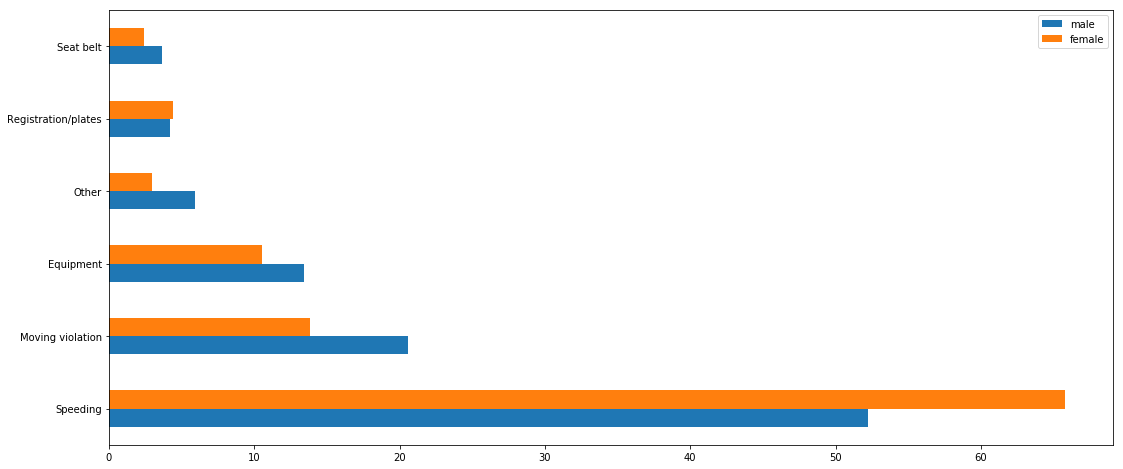

In [255]:
male = ri[ri.driver_gender == 'M']
mv = male.violation.value_counts(normalize=True).apply(lambda x: x * 100)

female = ri[ri.driver_gender == 'F']
fv = female.violation.value_counts(normalize=True).apply(lambda x: x * 100)

violations = pd.DataFrame({'male': mv, 'female': fv}, index=mv.index)
violations.plot.barh(figsize=[18,8])
plt.show()

So it seems that speeding is still the most common violation irrespective of gender, however from the data it seems females commit more speeding violations than males.

## Does gender affect who gets a ticket for speeding?

Since we have established that speeding is the most common violation irrespective of the gender of the driver, we will try to determine wether the gender of the driver has an impact on wether the diver will recieve a ticket for speeding.

We employ a similar method as before by segregating the cases for speeding into sets for male and female and then we check the outcomes.

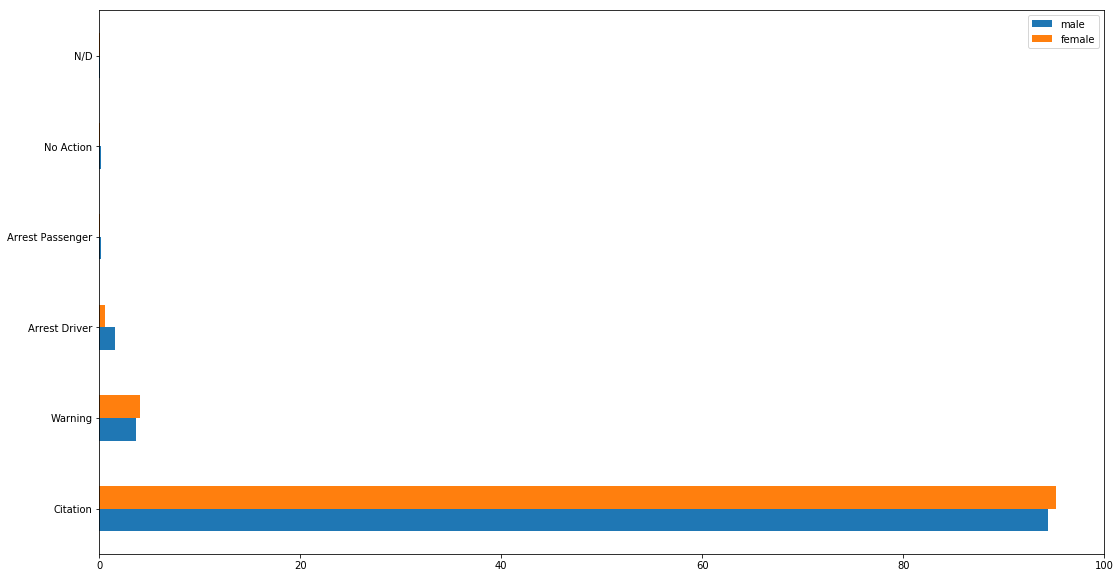

In [256]:
male_and_speeding = ri[(ri.driver_gender == 'M') & (ri.violation == 'Speeding')]
female_and_speeding = ri[(ri.driver_gender == 'F') & (ri.violation == 'Speeding')]

mso = male_and_speeding.stop_outcome.value_counts(normalize=True).apply(lambda x: x * 100)
fso = female_and_speeding.stop_outcome.value_counts(normalize=True).apply(lambda x: x * 100)

outcomes = pd.DataFrame({'male': mso, 'female': fso}, index=mso.index)
outcomes.plot.barh(figsize=(18,10))
plt.show()

So it seems that though tickets are issued for the majority of cases, the diffrence between the citation rates for male and female is almost negligible eventhough it seems that females have a higher rate of citations issued. 

## Does gender affect whose vehicle is searched?

To answer this question we will first try to compare the overall mean of searches conducted  with the respective means of male and female drivers.

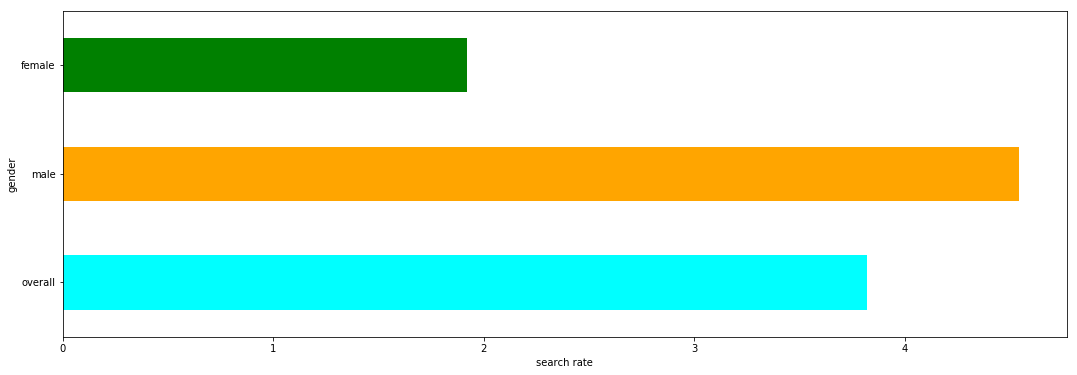

In [257]:
overall_search_pct  = ri.search_conducted.mean() * 100
male_search_pct = ri[ri.driver_gender == 'M'].search_conducted.mean() * 100
female_search_pct = ri[ri.driver_gender == 'F'].search_conducted.mean() * 100

searches = pd.DataFrame({'gender': ['overall', 'male', 'female'], 'search rate': [overall_search_pct, male_search_pct, female_search_pct]})
ax = searches.plot.barh(x='gender', y='search rate',figsize=(18,6), color=['cyan', 'orange', 'green'])
ax.get_legend().remove()
ax.set_xlabel('search rate')
plt.show()

Even though the search rate for males is much higher than for females, it's possible that the difference is mostly due to a second factor. We will compare the various violations for male vs female drivers and the percentage of which have led to a search being conducted. We can use this to test our hypothesis that the search rate varies by violation type, and the difference in search rate between males and females is because they tend to commit different violations. 

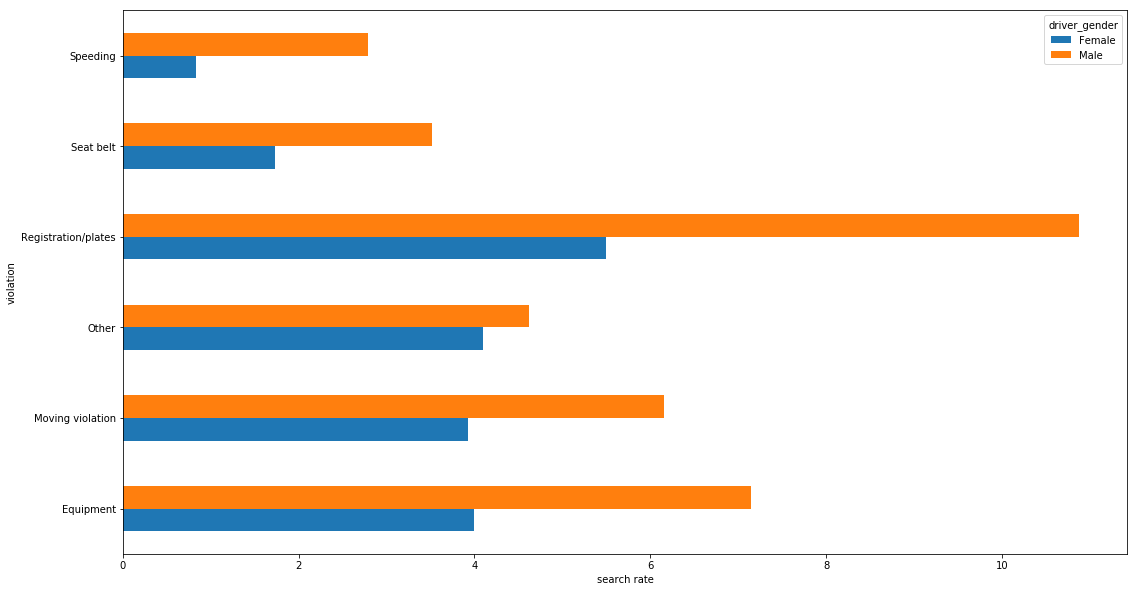

In [258]:
all_searches_grouped = ri.groupby(['driver_gender', 'violation']).search_conducted.mean() * 100
ax = all_searches_grouped.rename({'M': 'Male', 'F': 'Female'}).unstack(level=0).plot.barh(figsize=(18,10))
ax.set_xlabel('search rate')
plt.show()

We find that for all types of violations, the search rate is higher for males than for females, disproving our hypothesis.

## Does gender affect who is frisked during a search?

During a vehicle search, the police officer may pat down the driver to check if they have a weapon. This is known as a "protective frisk" . Lets take look on the search type to see that.

In [259]:
ri.search_type.value_counts()

Incident to Arrest                                          1290
Probable Cause                                               924
Inventory                                                    219
Reasonable Suspicion                                         214
Protective Frisk                                             164
Incident to Arrest,Inventory                                 123
Incident to Arrest,Probable Cause                            100
Probable Cause,Reasonable Suspicion                           54
Probable Cause,Protective Frisk                               35
Incident to Arrest,Inventory,Probable Cause                   35
Incident to Arrest,Protective Frisk                           33
Inventory,Probable Cause                                      25
Protective Frisk,Reasonable Suspicion                         19
Incident to Arrest,Inventory,Protective Frisk                 18
Incident to Arrest,Probable Cause,Protective Frisk            13
Inventory,Protective Fris

As we can see the word 'Proctective Frisk' occurs for few of the search types, we will create a boolean column labelled 'frisk' to highlight these cases. Then we can use this column as a filter to count the mean of male and female drivers respectively where a search has resulted in a frisk.

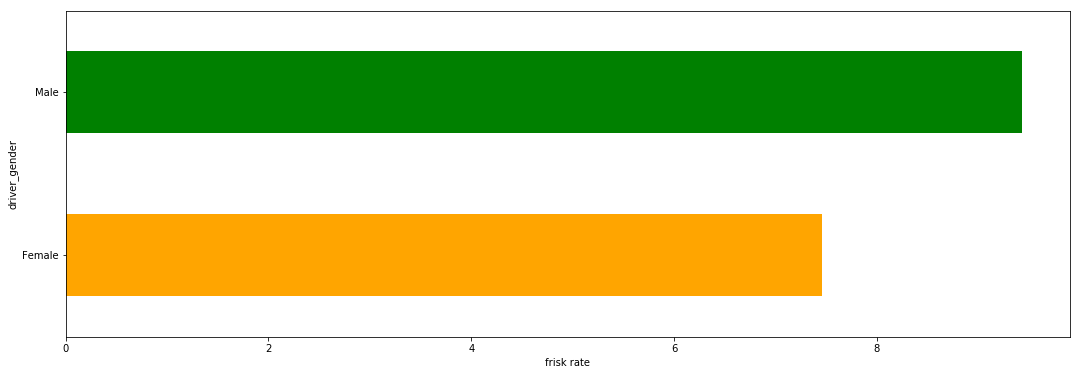

In [260]:
ri['frisk'] = ri.search_type.str.contains('Protective Frisk', na=False)
searched = ri[ri.search_conducted == True]

all_frisks_grouped = searched.groupby('driver_gender').frisk.mean() * 100
ax = all_frisks_grouped.rename({'M': 'Male', 'F': 'Female'}).plot.barh(figsize=(18,6), color=['orange', 'green'])
ax.set_xlabel('frisk rate')
plt.show()

The frisk rate is higher for males than for females, though we can't conclude that this difference is caused by the driver's gender.

## Does time of day affect arrest rate?

When a police officer stops a driver, a small percentage of those stops ends in an arrest. This is known as the arrest rate. We will first calculate the overall arrest rate (which can be easily done by a mean since the field is_arrested is a boolean), and also the hourly rate (since we have datetime index we can use hourly grouping and then take the mean). We can then plot the hourly arrest rate.

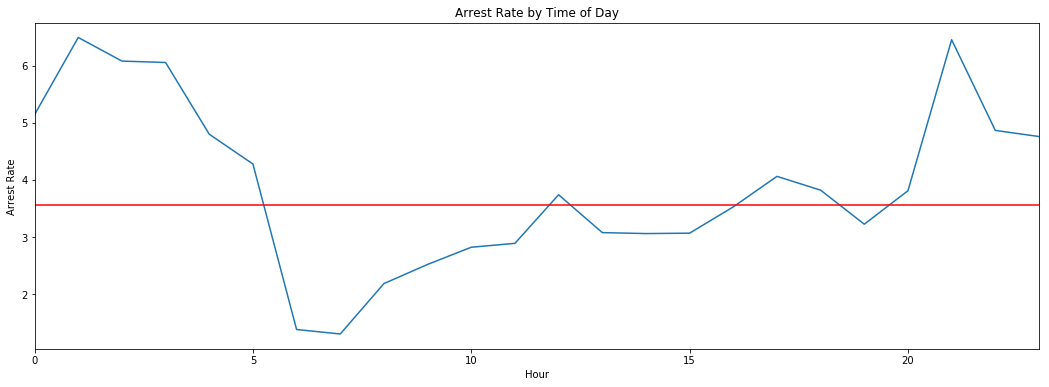

In [261]:
overall_arrest_rate = ri['is_arrested'].mean() * 100

hourly_arrest_rate = ri['is_arrested'].groupby(ri.index.hour).mean() * 100

hourly_arrest_rate.plot(figsize=(18,6))
plt.xlabel('Hour')
plt.ylabel('Arrest Rate')
plt.title('Arrest Rate by Time of Day')
plt.axhline(y=overall_arrest_rate, color='red')
plt.show()

The hourly arrest rate has a significant spike overnight, and then dips in the early morning hours.

## Are drug related stops on the rise?

In a small portion of traffic stops, drugs are found in the vehicle during a search. The boolean column drug_related_stop indicates wether drugs were found. We can calculate the annual rate by resampling (similar to the group by the hour but instead we use a year) the datetime sequence and then using a line plot to see the visualize the change over time

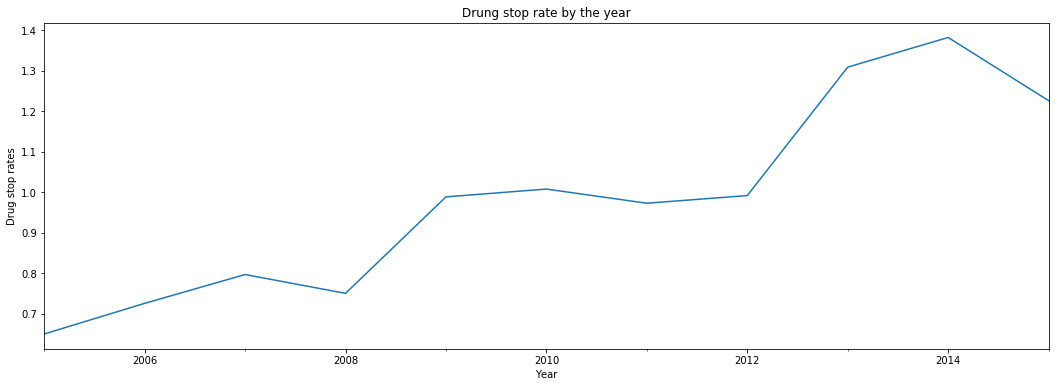

In [262]:
annual_drug_rate = ri.drugs_related_stop.resample('A').mean() * 100

annual_drug_rate.plot(figsize=(18,6))
plt.xlabel('Year')
plt.title('Drung stop rate by the year')
plt.ylabel('Drug stop rates')
plt.show()

The rate of drug-related stops increased significantly between 2005 and 2015. We might hypothesize that the rate of vehicle searches was also increasing, which would have led to an increase in drug-related stops even if more drivers were not carrying drugs.

We can test this hypothesis by calculating the annual search rate (exctaly the way we calculated the drug stop rate), and then plotting it against the annual drug rate. If the hypothesis is true, the rates should increasing over time.

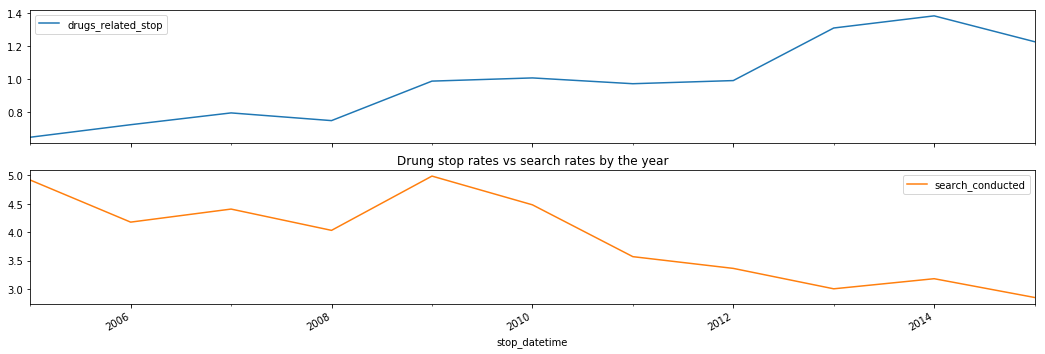

In [263]:
annual_search_rate = ri.search_conducted.resample('A').mean() * 100

annual_rate = pd.concat([annual_drug_rate, annual_search_rate], axis=1)
annual_rate.plot(figsize=(18,6), subplots=True)
plt.title('Drung stop rates vs search rates by the year')
plt.show()

The rate of drug-related stops increased even though the search rate decreased, disproving our hypothesis.

## What violations are caused by each district? 

The state of Rhode Island is broken into six police districts, also known as zones. We will try to analyse how the zones compare in terms of violations caught by police. To count the violations we create a frequency table for all violations grouped by their district.



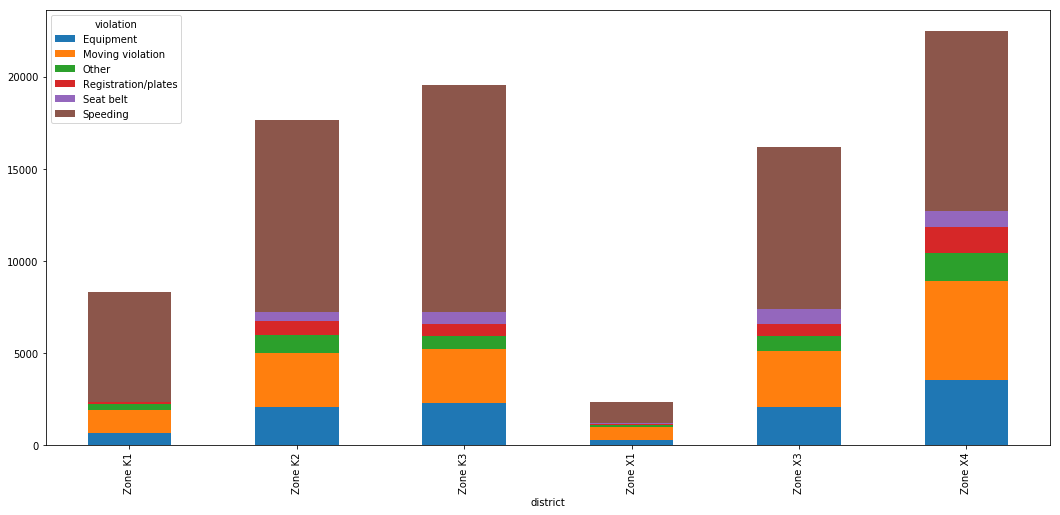

In [264]:
all_zones = pd.crosstab(ri.district, ri.violation)
all_zones.plot(kind='bar', stacked=True, figsize=(18,8))
plt.show()

It seems that the vast majority of traffic stops in Zone K1 are for speeding, and Zones K2 and K3 are remarkably similar to one another in terms of violations.

## How long might one be stopped for a violation?

Unfortunately the stop_duration column only has a range like '0-15 Min' as the duration. We start first by examining the unique values for this field.

In [265]:
print(ri.stop_duration.unique())

['0-15 Min' '16-30 Min' '30+ Min']


We can assume the average values of the limits for such stops to be average duration in minutes for these stops. E.g. 0-15 minutes is 8 minutes, 16-30 minutes is 23 minutes etc and we apply a conversion accordingly as a new column stop_minutes. Grouping by the violation_raw column we can get the average duration for a given violation.

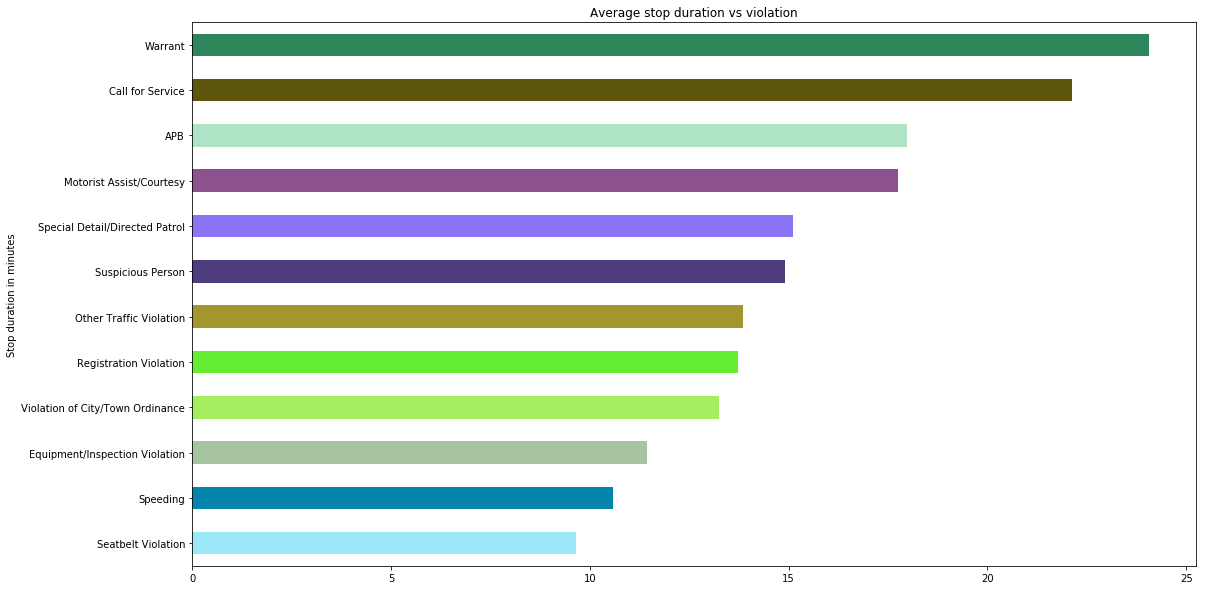

In [266]:
mapping = {'0-15 Min': 8, '16-30 Min': 23, '30+ Min': 45}
ri['stop_minutes'] = ri.stop_duration.map(mapping)

stop_length = ri.groupby(['violation_raw']).stop_minutes.mean() 
stop_length.sort_values().plot(kind='barh', figsize=(18,10), color=np.random.rand(len(stop_length), 3))
plt.title('Average stop duration vs violation')
plt.ylabel('Violation')
plt.ylabel('Stop duration in minutes')
plt.show()

The answers aren't surprising an average stop will last most for serious offences involving a warrant (possibly due to higher procedural complexities) and the least for realitively minor offences like speeding etc

## Exploring the weather dataset

We need to examine the temperature columns from the weather dataset to assess whether the data seems trustworthy.

In [267]:
weather = pd.read_csv('data/weather.csv')
weather.head()

,STATION,DATE,TAVG,TMIN,TMAX,AWND,WSF2,WT01,WT02,WT03,...,WT11,WT13,WT14,WT15,WT16,WT17,WT18,WT19,WT21,WT22
0,USW00014765,2005-01-01,44.0,35,53,8.95,25.1,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,USW00014765,2005-01-02,36.0,28,44,9.40,14.1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,USW00014765,2005-01-03,49.0,44,53,6.93,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,USW00014765,2005-01-04,42.0,39,45,6.93,16.1,1.0,NaN,NaN,...,NaN,1.0,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,USW00014765,2005-01-05,36.0,28,43,7.83,17.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN


We are interested more in the temperature columns TMIN, TAVG, TMAX describing the daily minimum, average and maximum temperatues respectively. A box plot should help us examine if the temperatures (measured in Fahrenheit) have reasonable values.

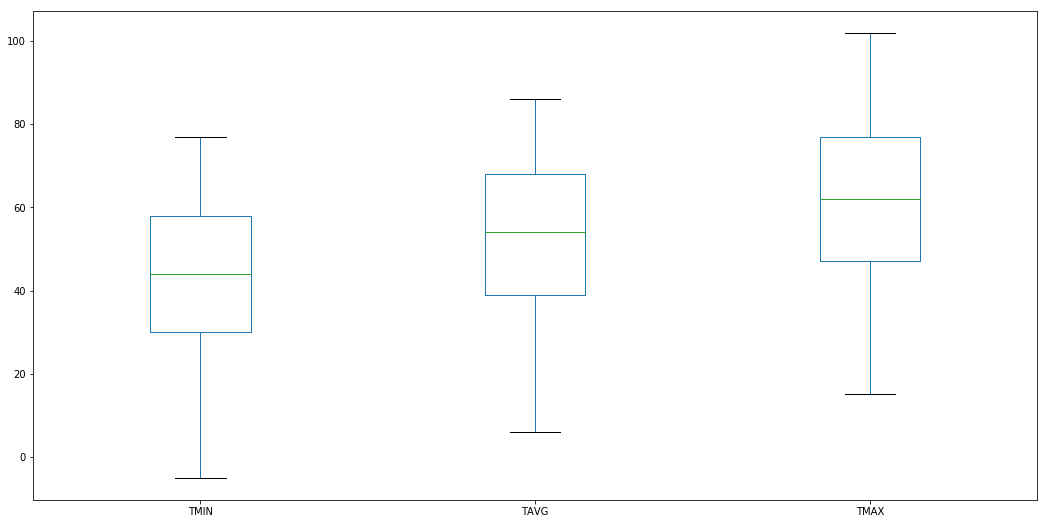

In [268]:
weather[['TMIN', 'TAVG', 'TMAX']].plot(kind='box', figsize=(18,9))
plt.show()

All temperature measurements seem to be reasonable. So we can now evaluate "how bad" the weather was. In the dataset the columns beginning withe the name WT indicates a bad weather condition e.g.

- **WT01** indicates "Hail"
- **WT11** indicates "High or damaging winds"
- **WT17** indicates "Freezing rain"

To quantify how bad the weather was we can sum up the values of every row (as occurance of a bad weather condition is indicated by 1 and abscence by a NaN) and then convert the sums to integers (there will be NaN values in the sum indicating days with bad weather, for such cases we replace NaN with a zero) and plot a histogram to view the frequency of bad weather.

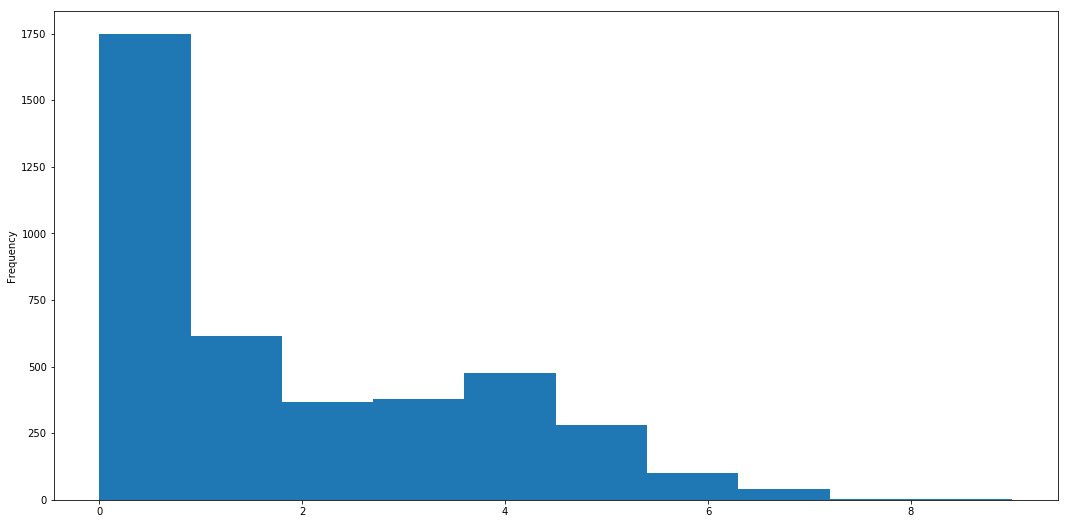

In [269]:
weather['bad_conditions'] = weather.loc[:, 'WT01':'WT22'].sum(axis='columns').fillna(0).astype(int)
weather['bad_conditions'].plot(kind='hist', figsize=(18,9))
plt.show()

It looks like many days didn't have any bad weather conditions, and only a small portion of days had more than four bad weather conditions. We can now create a rating system based on the count of bad weather conditions for a given day:
- 0 - 'good'
- 1 to 4 - 'bad' 
- 5 to 9 - 'worse' 

Once done we can store this info as a categorical type to increase efficiency.

In [270]:
weather['rating'] = weather.bad_conditions.map(lambda x: 'good' if x == 0 else 'bad' if x >= 1 and x <= 4 else 'worse', na_action=None)
weather.rating.value_counts().sort_index()
weather['rating'] = weather.rating.astype(pd.api.types.CategoricalDtype(ordered=True, categories=['good', 'bad', 'worse']))

Since we have a weather dataset with categorised weather conditions, we can now merge the weather dataset (just the date and the weather rating) with the police activity dataset based on the DATE and stop_date columns respectively. However the index field stop_datetime will be lost as an index field, to prevent this we first convert stop_datetime into a non-index column, do the merge and the set it back as the index.


In [274]:
ri.reset_index(inplace=True)
weather_rating = weather[['DATE', 'rating']]
ri_weather = pd.merge(left=ri, right=weather_rating, left_on='stop_date', right_on='DATE', how='left')
ri_weather.set_index('stop_datetime', inplace=True)

## Does weather affect the arrest rate? 

To find out if police officers arrest drivers more often when the weather is bad, we generate the arrest rate by weather by pivoting on weather rating by taking a mean of the arrest and index it on violations.

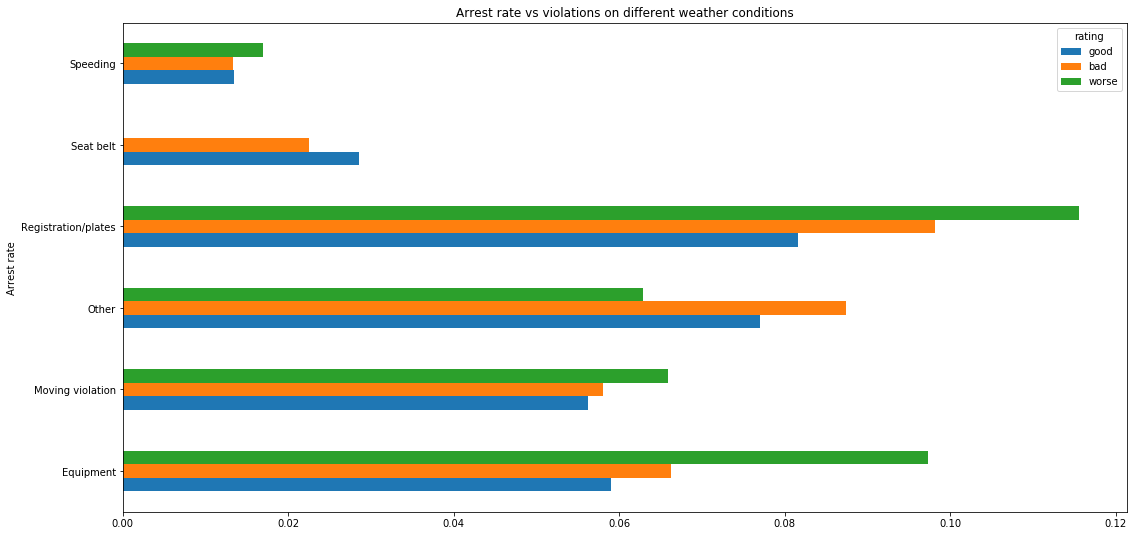

In [284]:
arrest_rate = ri_weather.pivot_table(index='violation', columns='rating', values='is_arrested')
arrest_rate.apply(lambda x: x * 100)
arrest_rate.plot(kind='barh', figsize=(18,9))
plt.title('Arrest rate vs violations on different weather conditions')
plt.ylabel('Violation')
plt.ylabel('Arrest rate')
plt.show()

In conclusion for most of the cases we see an increase of arrest rate when the weather turns bad from good and worse. The violation type 'Other' can be considered an outlier in this case as it groups all other conditions together possibly murking the results.